
# Project 1: Build an LLM Playground

Welcome! In this project, you’ll learn foundations of large language models (LLMs). We’ll keep the code minimal and the explanations high‑level so that anyone who can run a Python cell can follow along.  

We'll be using Google Colab for this project. Colab is a free, browser-based platform that lets you run Python code and machine learning models without installing anything on your local computer. Click the button below to open this notebook directly in Google Colab and get started!


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bytebyteai/ai-eng-projects/blob/main/project_1/lm_playground.ipynb)

---
## Learning Objectives  
* **Tokenization** and how raw text is tokenized into a sequene of discrete tokens
* Inspect **GPT2** and **Transformer architecture**
* Loading pre-trained LLMs using **Hugging Face**
* **Decoding strategies** to generate text from LLMs
* Completion versus **intrusction fine-tuned** LLMs


Let's get started!

In [1]:
import torch, transformers, tiktoken
print("torch", torch.__version__, "| transformers", transformers.__version__)

torch 2.8.0+cu126 | transformers 4.57.1


# 1 - Tokenization

A neural network can’t digest raw text. They need **numbers**. Tokenization is the process of converting text into IDs. In this section, you'll learn how tokenization is implemented in practice.

Tokenization methods generally fall into three categories:
1. Word-level
2. Character-level
3. Subword-level

### 1.1 - Word‑level tokenization

Split text on whitespace and store each **word** as a token.

In [14]:
# 1. Tiny corpus
corpus = [
    "The quick brown fox jumps over the lazy dog",
    "Tokenization converts text to numbers",
    "Large language models predict the next token"
]

words = set()
for word in corpus:
  words.update(word.lower().split())

# 2. Build the vocabulary
PAD, UNK = "[PAD]", "[UNK]"
vocab = [PAD,UNK] + list(words) # Vocabulary is separate from words so we can add special tokens for reasoning, control (e.g., end-of-sentence), padding, and handling non-text inputs like images.
word2id = {}
id2word = {}

for i, word in enumerate(vocab):
    word2id[word] = i
    id2word[i] = word

print(f"Vocabulary size: {len(vocab)} words")
print("First 15 vocab entries:", vocab[:15])

# 3. Encode / decode
def encode(text):
  out = []
  for word in text.lower().split():
    if word in word2id:
        out.append(word2id[word])
    else:
        out.append(word2id[UNK])
  return out

def decode(ids):
  words = []
  for i in ids:
    if i != word2id[PAD]: # we never want PAD in decoding
      words.append(id2word[i])
  return " ".join(words);

# 4. Demo
sample = "The brown unicorn jumps"
ids = encode(sample)
recovered = decode(ids)

print("\nInput text :", sample)
print("Token IDs  :", ids)
print("Decoded    :", recovered) #unicorn is an unknown word from the vocab ([UNK])

Vocabulary size: 21 words
First 15 vocab entries: ['[PAD]', '[UNK]', 'numbers', 'tokenization', 'language', 'next', 'text', 'quick', 'over', 'brown', 'large', 'predict', 'token', 'dog', 'models']

Input text : The brown unicorn jumps
Token IDs  : [16, 9, 1, 17]
Decoded    : the brown [UNK] jumps


Word-level tokenization has two major limitations:
1. Large vocabulary size
2. Out-of-vocabulary (OOV) issue

### 1.2 - Character‑level tokenization

Every single character (including spaces and emojis) gets its own ID. This guarantees zero out‑of‑vocabulary issues but very long sequences.

In [6]:
# 1. Build a fixed vocabulary # a–z + A–Z + padding + unkwown
import string

letters = list(string.ascii_lowercase + string.ascii_uppercase) + [" "]
special = ["[PAD]", "[UNK]"]
vocab = letters+special
char2id = {ch:index for index, ch in enumerate(vocab)}
id2char = {index:ch for ch,index in char2id.items()}

print(f"Vocabulary size: {len(vocab)} (52 letters + 2 specials)")

# 2. Encode / decode
def encode(text):
    return [char2id.get(ch,char2id["[UNK]"]) for ch in text]

def decode(ids):
    return "".join(id2char[i] for i in ids if i != char2id["[PAD]"])

# 3. Demo
sample = "Hi, how are you"
ids = encode(sample)
recovered = decode(ids)

print("\nInput text :", sample)
print("Token IDs  :", ids)
print("Decoded    :", recovered)


Vocabulary size: 55 (52 letters + 2 specials)

Input text : Hi, how are you
Token IDs  : [33, 8, 54, 52, 7, 14, 22, 52, 0, 17, 4, 52, 24, 14, 20]
Decoded    : Hi[UNK] how are you


### 1.3 - Subword‑level tokenization

Sub-word methods such as `Byte-Pair Encoding (BPE)`, `WordPiece`, and `SentencePiece` **learn** the most common character and gorup them into new tokens. For example, the word `unbelievable` might turn into three tokens: `["un", "believ", "able"]`. This approach strikes a balance between word-level and character-level methods and fix their limitations.

For example, `BPE` algorithm forms the vocabulary using the following steps:
1. **Start with bytes** → every character is its own token.  
2. **Count all adjacent pairs** in a huge corpus.  
3. **Merge the most frequent pair** into a new token.  
   *Repeat steps 2-3* until you hit the target vocab size (e.g., 50 k).

Let's see `BPE` in practice.

In [10]:
# 1. Load a pretrained BPE tokenizer (GPT-2 uses BPE).
# Refer to  https://huggingface.co/docs/transformers/en/fast_tokenizers

from transformers import AutoTokenizer
bpe_tok = AutoTokenizer.from_pretrained("gpt2")
print(bpe_tok)

# 2. Encode / decode
def encode(text):
    return bpe_tok.encode(text)

def decode(ids):
    return bpe_tok.decode(ids)

# 3. Demo
sample = "Unbelievable tokenization powers! 🚀"
ids = encode(sample)
recovered = decode(ids)

print("\nInput text :", sample)
print("Token IDs  :", ids)
print("Tokens     :", bpe_tok.convert_ids_to_tokens(ids))
print("Decoded    :", recovered)


GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

Input text : Unbelievable tokenization powers! 🚀
Token IDs  : [3118, 6667, 11203, 540, 11241, 1634, 5635, 0, 12520, 248, 222]
Tokens     : ['Un', 'bel', 'iev', 'able', 'Ġtoken', 'ization', 'Ġpowers', '!', 'ĠðŁ', 'ļ', 'Ģ']
Decoded    : Unbelievable tokenization powers! 🚀


### 1.4 - TikToken

`tiktoken` is a production-ready library which offers high‑speed tokenization used by OpenAI models.  
Let's compare the older **gpt2** encoding with the newer **cl100k_base** used in GPT‑4.

In [12]:
# Use gpt2 and cl100k_base to encode and decode the following text
# Refer to https://github.com/openai/tiktoken
import tiktoken

sentence = "The 🌟 star-player scored 40 points!"

encodings =[
    ("gpt2", tiktoken.get_encoding("gpt2")),
    ("cl100k_base", tiktoken.get_encoding("cl100k_base"))
]

for name, enc in encodings:
  print(f"\n=== {name} ===")
  print("Vocabulary size:",enc.n_vocab)

  # Encode the samepl sentence
  ids = enc.encode(sentence)
  tokens = [enc.decode([i]) for i in ids]
  print(f"'sentence splits into {len(ids)} tokens: ")
  print(list(zip(tokens, ids)))


=== gpt2 ===
Vocabulary size: 50257
'sentence splits into 11 tokens: 
[('The', 464), (' �', 12520), ('�', 234), ('�', 253), (' star', 3491), ('-', 12), ('player', 7829), (' scored', 7781), (' 40', 2319), (' points', 2173), ('!', 0)]

=== cl100k_base ===
Vocabulary size: 100277
'sentence splits into 11 tokens: 
[('The', 791), (' �', 11410), ('�', 234), ('�', 253), (' star', 6917), ('-player', 43467), (' scored', 16957), (' ', 220), ('40', 1272), (' points', 3585), ('!', 0)]


Experiment: try new sentences, emojis, code snippets, or other languages. If you are interested, try implementing the BPE algorithm yourself.

### 1.5 - Key Takeaways

* **Word‑level**: simple but brittle (OOV problems).  
* **Character‑level**: robust but produces long sequences.  
* **BPE / Byte‑Level BPE**: middle ground used by most LLMs.  
* **tiktoken**: shows how production models tokenize with pre‑trained sub‑word vocabularies.

# 2. What is a Language Model?

At its core, a **language model (LM)** is just a *very large* mathematical function built from many neural-network layers.  
Given a sequence of tokens `[t₁, t₂, …, tₙ]`, it learns to output a probability for the next token `tₙ₊₁`.


Each layer applies a simple operation (matrix multiplication, attention, etc.). Stacking hundreds of these layers lets the model capture patterns and statistical relations from text. The final output is a vector of scores that says, “how likely is each possible token to come next?”

> Think of the whole network as **one gigantic equation** whose parameters were tuned during training to minimize prediction error.



### 2.1 - A Single `Linear` Layer

Before we explore Transformer, let’s start tiny:

* A **Linear layer** performs `y = Wx + b`  
  * `x` – input vector  
  * `W` – weight matrix (learned)  
  * `b` – bias vector (learned)

Although this looks basic, chaining thousands of such linear transforms (with nonlinearities in between) gives neural nets their expressive power.


In [9]:
# here to implement our own linear, but in practice we can just torch.Linear
import torch.nn as nn
import torch

class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super(Linear, self).__init__()
        self.weights = nn.Parameter(torch.randn(out_features, in_features))

    def forward(self, x):
        return torch.matmul(x, self.weights.t())

linear = Linear(3, 4) #input feafures: 3 output features: 4
x = torch.rand(1,3)
y = linear(x)
print(y)

tensor([[ 0.9260,  1.4816,  0.5372, -0.9550]], grad_fn=<MmBackward0>)


In [10]:
import torch.nn as nn, torch

lin = nn.Linear(3, 2)
x = torch.tensor([1.0, -1.0, 0.5])
print("Input :", x)
print("Weights:", lin.weight)
print("Bias   :", lin.bias)
print("Output :", lin(x))


Input : tensor([ 1.0000, -1.0000,  0.5000])
Weights: Parameter containing:
tensor([[ 0.4786,  0.4382, -0.0340],
        [ 0.1609, -0.1636, -0.1613]], requires_grad=True)
Bias   : Parameter containing:
tensor([ 0.2742, -0.1488], requires_grad=True)
Output : tensor([0.2976, 0.0951], grad_fn=<ViewBackward0>)


### 2.2 - A `Transformer` Layer

Most LLMs are a **stack of identical Transformer blocks**. Each block fuses two main components:

| Step | What it does | Where it lives in code |
|------|--------------|------------------------|
| **Multi-Head Self-Attention** | Every token looks at every other token and decides *what matters*. | `block.attn` |
| **Feed-Forward Network (MLP)** | Re-mixes information token-by-token. | `block.mlp` |

Below, we load the smallest public GPT-2 (124 M parameters), grab its *first* block, and inspect the pieces.


In [3]:
import torch
from transformers import GPT2LMHeadModel
# Load the 124 M-parameter GPT-2 and inspect its layers
gpt2=GPT2LMHeadModel.from_pretrained("gpt2")
gpt2

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
#inspect gpt2's layers in the block
block = gpt2.transformer.h[0]
block
for name,module in block.named_children():
    print(name, module.__class__.__name__)

ln_1 LayerNorm
attn GPT2Attention
ln_2 LayerNorm
mlp GPT2MLP


In [6]:
gpt2.config # learn the config that was used to train gpt2

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "dtype": "float32",
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.57.1",
  "use_cache": true,
  "vocab_size": 50257
}

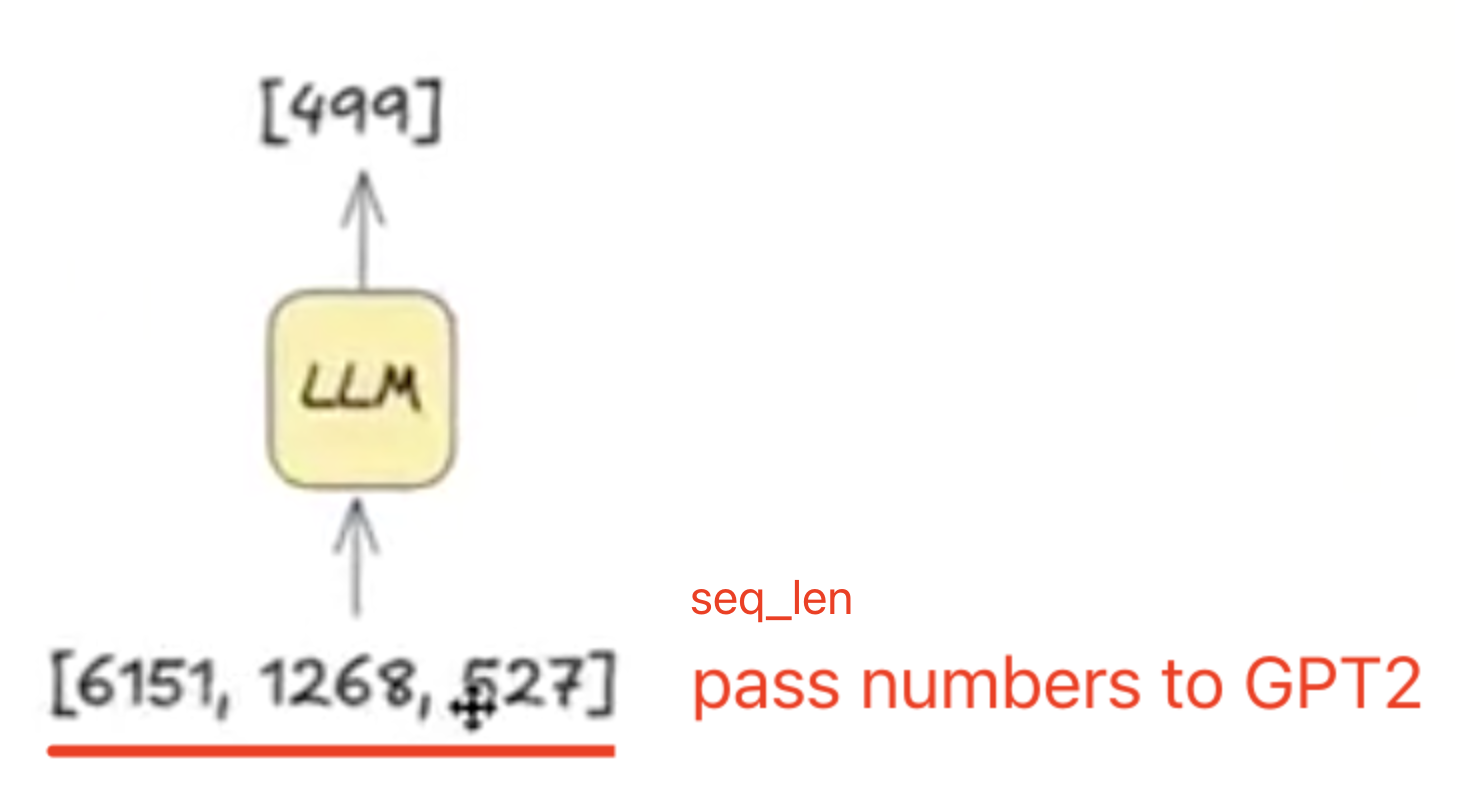

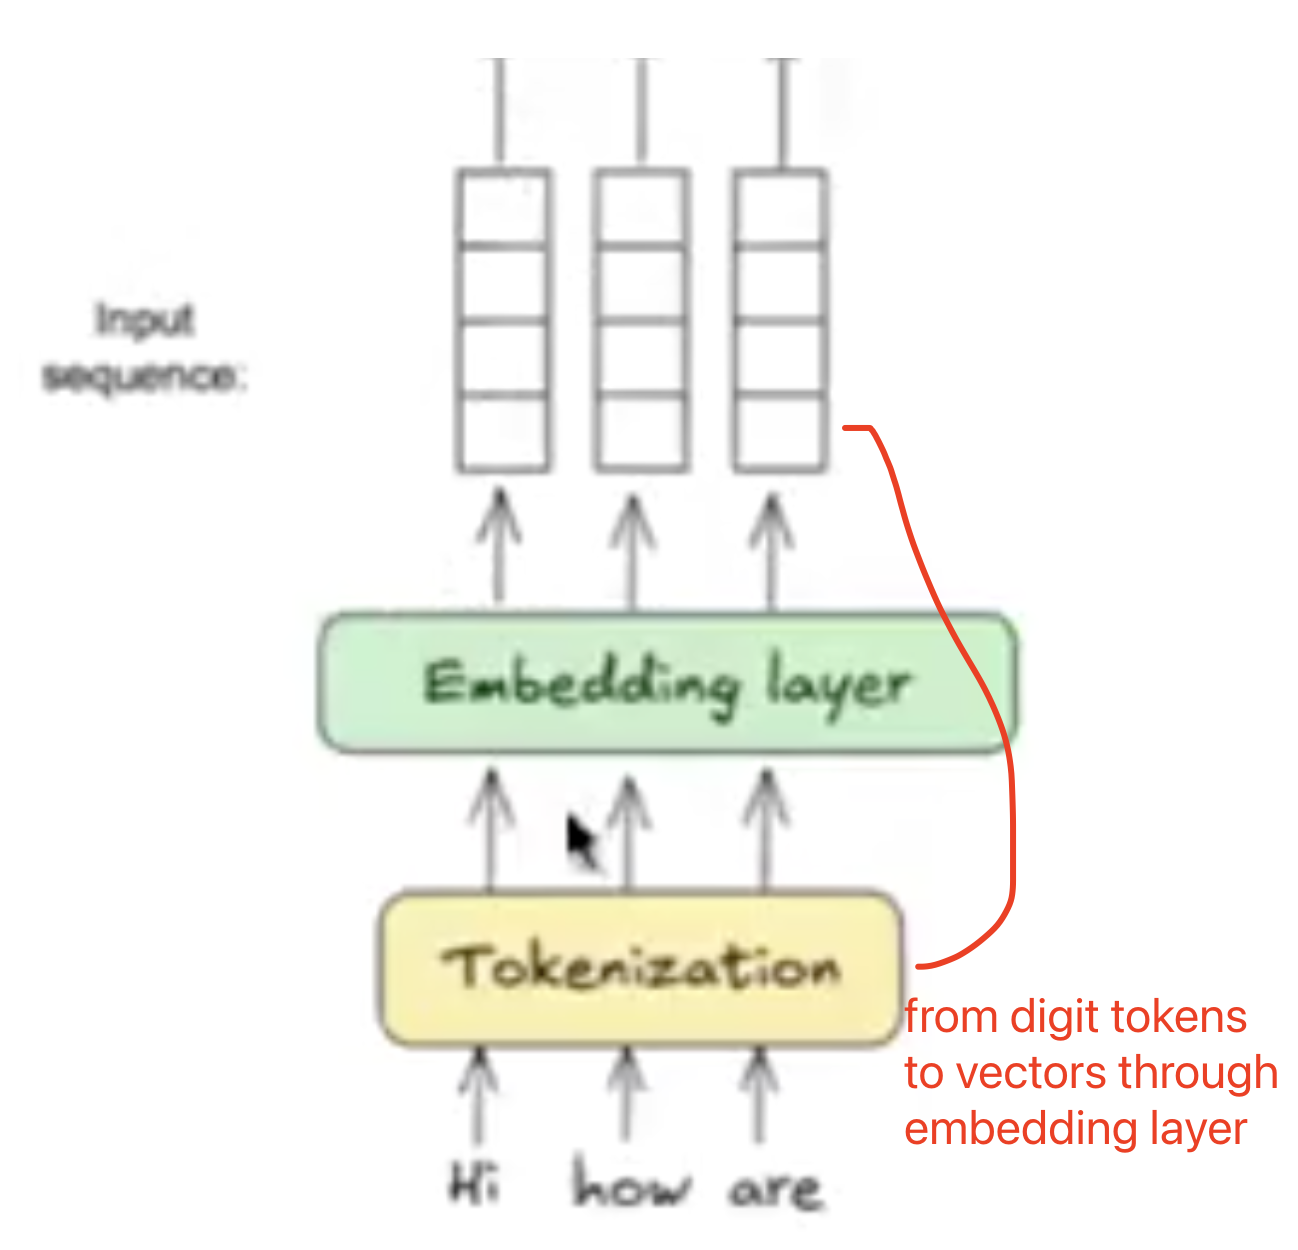

In [8]:
# Run a tiny forward pass through the first block
seq_len = 8
dummy_tokens = torch.randint(0, gpt2.config.vocab_size, (1, seq_len))
with torch.no_grad():
    # Embed tokens + positions the same way GPT-2 does
    # Forward through one layer
    hidden = gpt2.transformer.wte(dummy_tokens) + gpt2.transformer.wpe(torch.arange(seq_len))
    out = block(hidden)[0]

print("\nOutput shape :", out.shape) # (batch, seq_len, hidden_size)


Output shape : torch.Size([1, 8, 768])


### 2.3 - Inside GPT-2

GPT-2 is just many of those modules arranged in a repeating *block*. Let's print the modules inside the Transformer.

In [ ]:
# Print the name and modules inside gpt2
"""
YOUR CODE HERE
"""

As you can see, the Transformer holds various modules, arranged from a list of blocks (`h`). The following table summarizes these modules:

| Step | What it does | Why it matters |
|------|--------------|----------------|
| **Token → Embedding** | Converts IDs to vectors | Gives the model a numeric “handle” on words |
| **Positional Encoding** | Adds “where am I?” info | Order matters in language |
| **Multi-Head Self-Attention** | Each token asks “which other tokens should I look at?” | Lets the model relate words across a sentence |
| **Feed-Forward Network** | Two stacked Linear layers with a non-linearity | Mixes information and adds depth |
| **LayerNorm & Residual** | Stabilize training and help gradients flow | Keeps very deep networks trainable |


### 2.4 LLM's output

Passing a token sequence through an **LLM** yields a tensor of **logits** with shape  
`(batch_size, seq_len, vocab_size)`.  
Applying `softmax` on the last dimension turns those logits into probabilities.

The cell below feeds an 8-token dummy sequence, prints the logits shape, and shows the five most likely next tokens for the final position.


In [ ]:
import torch, torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

# Load gpt2 model and tokenizer
"""
YOUR CODE HERE
"""

# Tokenize input text
text = "Hello my name"
"""
YOUR CODE HERE
"""

# Get logits by passing the ids to the gpt2 model.
"""
YOUR CODE HERE
"""

print("Logits shape :", logits.shape)

# Predict next token
"""
YOUR CODE HERE
"""

print("\nTop-5 predictions for the next token:")
"""
YOUR CODE HERE
"""


### 2.5 - Key Takeaway

A language model is nothing mystical: it’s a *huge composition* of small, understandable layers trained to predict the next token in a sequence of tokens.

# 3 - Generation
Once an LLM is trained to predict the probabilities, we can generate text from the model. This process is called decoding or sampling.

At each step, the LLM outputs a **probability distribution** over the next token. It is the job of the decoding algorithm to pick the next token, and move on to the next token. There are different decoding algorithms and hyper-parameters to control the generaiton:
* **Greedy** → pick the single highest‑probability token each step (safe but repetitive).  
* **Top‑k / Nucleus (top‑p)** → sample from a subset of likely tokens (adds variety).
* **beam** -> applies beam search to pick tokens
* **Temperature** → a *creativity* knob. Higher values flatten the probability distribution.

### 3.1 - Greedy decoding

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
MODELS = {
    "gpt2": "gpt2",
}
tokenizers, models = {}, {}
# Load models and tokenizers
"""
YOUR CODE HERE
"""

def generate(model_key, prompt, strategy="greedy", max_new_tokens=100):
    tok, mdl = tokenizers[model_key], models[model_key]
    # Return the generations based on the provided strategy: greedy, top_k, top_p
    """
    YOUR CODE HERE
    """


In [ ]:
tests=["Once upon a time","What is 2+2?", "Suggest a party theme."]
for prompt in tests:
    print(f"\n== GPT-2 | Greedy ==")
    print(generate("gpt2", prompt, "greedy", 80))



Naively picking the single best token every time has the following issues in practice:

* **Loop**: “The cat is is is…”  
* **Miss long-term payoff**: the highest-probability word *now* might paint you into a boring corner later.

### 3.2 - Top-k or top-p sampling

In [ ]:

tests=["Once upon a time","What is 2+2?", "Suggest a party theme."]
for prompt in tests:
    print(f"\n== GPT-2 | Top-p ==")
    print(generate("gpt2", prompt, "top-p", 40))


### 3.3 - Try It Yourself

1. Scroll to the list called `tests`.
2. Swap in your own prompts or tweak the decoding strategy.  
3. Re‑run the cell and compare the vibes.

> **Tip:** Try the same prompt with `greedy` vs. `top_p` (0.9) and see how the tone changes. Notice especially how small temperature tweaks can soften or sharpen the prose.

* `strategy`: `"greedy"`, `"beam"`, `"top_k"`, `"top_p"`  
* `temperature`: `0.2 – 2.0`  
* `k` or `p` thresholds



# 4 - Completion vs. Instruction-tuned LLMs

We have seen that we can use GPT2 model to pass an input text and generate a new text. However, this model only continues the provided text. It is not engaging in a dialouge-like conversation and cannot be helpful by answering instructions. On the other hand, **instruction-tuned LLMs** like `Qwen-Chat` go through an extra training stage called **post-training** after the base “completion” model is finished. Because of post-training step, an instruction-tuned LLM will:

* **Read the entire prompt as a request,** not just as text to mimic.  
* **Stay in dialogue mode**. Answer questions, follow steps, ask clarifying queries.  
* **Refuse or safe-complete** when instructions are unsafe or disallowed.  
* **Adopt a consistent persona** (e.g., “Assistant”) rather than drifting into story continuation.


### 4.1 - Qwen1.5-8B vs. GPT2

In the code below we’ll feed the same prompt to:

* **GPT-2 (completion-only)** – it will simply keep writing in the same style.  
* **Qwen-Chat (instruction-tuned)** – it will obey the instruction and respond directly.

Comparing the two outputs makes the difference easy to see.

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
MODELS = {
    "gpt2": "gpt2",
    "qwen": "Qwen/Qwen1.5-1.8B-Chat"
}
tokenizers, models = {}, {}
# Load models and tokenizers
"""
YOUR CODE HERE
"""



We downloaded two tiny checkpoints: `GPT‑2` (124 M parameters) and `Qwen‑1.5‑Chat` (1.8 B). If the cell took a while, that was mostly network time. Models are stored locally after the first run.

Let's now generate text and compare two models.


In [ ]:

tests=[("Once upon a time","greedy"),("What is 2+2?","top_k"),("Suggest a party theme.","top_p")]
for prompt,strategy in tests:
    for key in ["gpt2","qwen"]:
        print(f"\n== {key.upper()} | {strategy} ==")
        print(generate(key,prompt,strategy,80))


# 5. (Optional) A Small LLM Playground

### 5.1 ‑ Interactive Playground

Enter a prompt, pick a model and decoding strategy, adjust the temperature, and press **Generate** to watch the model respond.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Make sure models and tokenizers are loaded
try:
    tokenizers
    models
except NameError:
    raise RuntimeError("Please run the earlier setup cells that load the models before using the playground.")

def generate_playground(model_key, prompt, strategy="greedy", temperature=1.0, max_new_tokens=100):
    # Generation code
    """
    YOUR CODE HERE
    """

# Your code to build boxes, dropdowns, and other elements in the UI using widgets and creating the UI using widgets.vbox and display.
# Refer to https://ipywidgets.readthedocs.io/en/stable/
"""
YOUR CODE HERE
"""



## 🎉 Congratulations!

You’ve just learned, explored, and inspected a real **LLM**. In one project you:
* Learned how **tokenization** works in practice
* Used `tiktoken` library to load and experiment with most advanced tokenizers.
* Explored LLM architecture and inspected GPT2 blocks and layers
* Learned decoding strategies and used `top-p` to generate text from GPT2
* Loaded a powerful chat model, `Qwen1.5-8B` and generated text
* Built an LLM playground


👏 **Great job!** Take a moment to celebrate. You now have a working mental model of how LLMs work. The skills you used here power most LLMs you see everywhere.
